# **Arturo Lazcano**

# Transfer Learning

En este notebook resolveremos un problema real usando redes pre-entrenadas y transfer learning.

## Patrones geométricos de Kunisch
En el año 1998, Norbert Kunisch (un reconocido arqueólogo clásico alemán) publicó su libro "Ornamente Geometrischer Vasen", en donde clasificó diferentes patrones geométricos de vasijas griegas que se encuentran en diferentes museos de Europa. Su trabajo fue muy importante para determinar tiempos y ubicaciones de muchos objetos esparcidos por todo el continente.

Su libro es un compendio de los diferentes patrones geométricos presentes en vasijas y las anotaciones textuales de los patrones en diferentes idiomas.

<img src="http://www.ivan-sipiran.com/downloads/0.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/6.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/36.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/92.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/210.jpg" alt="Test" height="200" />








# El problema

En el museo de arqueología Schloss Eggenberg quieren realizar un análisis automático de patrones en vasijas usando el compendio de Kunisch. Para esto nosotros realizamos primero un trabajo de escaneo del libro entero y de OCR para extraer tanto los patrones como las anotaciones textuales.

Como resultado tenemos 348 patrones, clasificados en seis clases:

*   Ornamentos circulares
*   Ornamentos triangulares
*   Ornamenros rectangulares
*   Pictografías
*   Trazos y líneas
*   Romboidales

Nuestro primer objetivo es encontrar una forma de lograr una alta eficacia de clasificación de estos patrones. Sin embargo, al tener muy poca data, trataremos de resolverlo con la técnica dle transfer learning.



In [1]:
#Descargamos la data
!wget http://www.ivan-sipiran.com/downloads/data_patterns2.zip
!unzip data_patterns2.zip

--2023-10-23 22:42:16--  http://www.ivan-sipiran.com/downloads/data_patterns2.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28575047 (27M) [application/zip]
Saving to: ‘data_patterns2.zip’

data_patterns2.zip  100%[===================>]  27.25M  27.2MB/s    in 1.0s    

2023-10-23 22:42:18 (27.2 MB/s) - ‘data_patterns2.zip’ saved [28575047/28575047]

Archive:  data_patterns2.zip
   creating: data/
  inflating: data/class_labels.csv   
  inflating: data/0.jpg              
  inflating: data/6.jpg              
  inflating: data/36.jpg             
  inflating: data/92.jpg             
  inflating: data/210.jpg            
   creating: data/patrones/
   creating: data/patrones/69c/
  inflating: data/patrones/69c/69c_pattern.png  
   creating: data/patrones/2a/
  inflating: data/patrones/2a/2a_pattern.png  
   creating:

# La Solución

Primero creamos nuestras tres colecciones de datos: train, val y test. Los datos de train serán usados para entrenar el modelo, los datos de validación serán usados para probar el modelo durante entrenamiento, y los datos de test serán usados para evaluar el performance final del modelo.

Hacemos un poco de data engineering para crear nuestras colecciones.

*   Datos de train: 70%
*   Datos de val: 10%
*   Datos de test: 20%

La partición se hace dentro de cada clase para asegurar representatividad en cada clase.



In [2]:
import pandas as pd
import math
import random
import os
import shutil

random.seed(30)

#Leemos la metadata del dataset desde el archivo CSV

df = pd.read_csv('data/class_labels.csv', header=None)
classes = df[1].unique()
classesFinal = [cl.replace(' ', '_') for cl in classes]
print(classesFinal)

#Creamos folders para almacenar la data. NOTA: trata de ejecutar esta celda solo una vez, ya que
# crea los folders y ese paso solo se ejecuta una vez
try:
  os.mkdir('dataset')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/train')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/test')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/val')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

for cl in classesFinal:
  try:
    os.mkdir(os.path.join('dataset', "train", cl))
  except OSError:
    print (f"No se pudo crear folder train {cl}")
  else:
    print (f"Se creó folder train {cl}")

  try:
    os.mkdir(os.path.join('dataset', "test", cl))
  except OSError:
    print (f"No se pudo crear folder test {cl}")
  else:
    print (f"Se creó folder test {cl}")

  try:
    os.mkdir(os.path.join('dataset', "val", cl))
  except OSError:
    print (f"No se pudo crear folder val {cl}")
  else:
    print (f"Se creó folder val {cl}")


['circular_ornaments', 'triangular_ornaments', 'rectangular_ornaments', 'pictographics', 'lozenge', 'strokes_and_lines']
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder train circular_ornaments
Se creó folder test circular_ornaments
Se creó folder val circular_ornaments
Se creó folder train triangular_ornaments
Se creó folder test triangular_ornaments
Se creó folder val triangular_ornaments
Se creó folder train rectangular_ornaments
Se creó folder test rectangular_ornaments
Se creó folder val rectangular_ornaments
Se creó folder train pictographics
Se creó folder test pictographics
Se creó folder val pictographics
Se creó folder train lozenge
Se creó folder test lozenge
Se creó folder val lozenge
Se creó folder train strokes_and_lines
Se creó folder test strokes_and_lines
Se creó folder val strokes_and_lines


In [3]:
#Hacemos el pre-procesamiento de los datos, cada imagen va a parar a su respectivo folder
dataset = dict()

for index, cl in enumerate(classes):
    grouped_data = df.groupby(1).get_group(cl)[0].tolist()
    dataset[classesFinal[index]] = grouped_data

for k,v in dataset.items():
    print(f'Class: {k}, Length: {len(v)}')

for k,v in dataset.items():
    valNumber = math.ceil(0.1 * len(v))
    testNumber = math.ceil(0.2 * len(v))
    trainNumber = len(v) - valNumber - testNumber

    random.shuffle(v)
    elemTrain = v[:trainNumber]
    elemVal = v[trainNumber:trainNumber+valNumber]
    elemTest = v[trainNumber+valNumber:]

    assert (valNumber + testNumber + trainNumber) == len(v)

    pathTrain = './dataset/train/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemTrain:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTrain, k))

    pathTest = './dataset/test/'
    pathSource = './data/patrones/'

    #Copiar archivos de test
    for elem in elemTest:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTest, k))

    pathVal = './dataset/val/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemVal:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathVal, k))

Class: circular_ornaments, Length: 72
Class: triangular_ornaments, Length: 81
Class: rectangular_ornaments, Length: 87
Class: pictographics, Length: 26
Class: lozenge, Length: 46
Class: strokes_and_lines, Length: 36


#Creación de Datasets

Se crean los datasets y dataloaders de Pytorch, que usarás para tu tarea.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

pathDataset = 'dataset/'

train_dataset = torchvision.datasets.ImageFolder(pathDataset + 'train',
                                                    transform = transforms.Compose([
                                                        transforms.RandomVerticalFlip(),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.RandomResizedCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

val_dataset = torchvision.datasets.ImageFolder(pathDataset + 'val',
                                                    transform = transforms.Compose([ transforms.Resize(256),
                                                                    transforms.CenterCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

test_dataset = torchvision.datasets.ImageFolder(pathDataset + 'test',
                                                    transform = transforms.Compose([ transforms.Resize(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


# Solución 1: Fine-tuning

Utiliza fine-tuning para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.



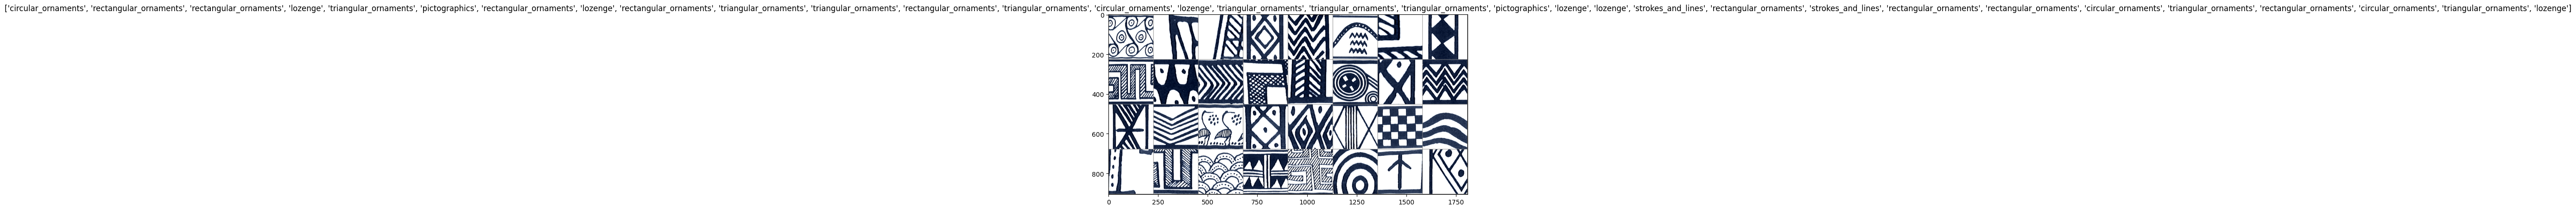

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

class_names = train_dataset.classes

def imshow(inp, title = None):
  plt.figure(figsize=(10,20))
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5])
  std = np.array([0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

En la celda anterior se puede ver una figura con bastantes imagenes en la grilla con el título correspondiente. No se cambia el tamaño pues esto afecta después a la visualización de la predicción del modelo.

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    #Train model
    #scheduler.step()
    model.train()

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    #Validation
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects.double() / len(val_dataset)

    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accuracy {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [7]:
def visualize_model(model, num_images = 6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far +=1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

In [11]:
#model_ft = models.googlenet(weights="IMAGENET1K_V1")
model_ft = models.resnet50(weights="IMAGENET1K_V2")
#model_ft = models.resnet50(weights="IMAGENET1K_V1")


print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
# Seed
seed = 20
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

# Fine tuning
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, len(class_names))

#num_ft = model_ft.classifier.in_features
#model_ft.classifier = nn.Linear(num_ft, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model_ft.parameters())
#optimizer = torch.optim.AdamW(model_ft.parameters(), lr=0.001)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 1.7616 Acc: 0.1907
Val Loss: 1.7586 Acc: 0.3684
Epoch 1/24
----------
Train Loss: 1.7075 Acc: 0.3814
Val Loss: 1.7124 Acc: 0.3684
Epoch 2/24
----------
Train Loss: 1.6364 Acc: 0.4407
Val Loss: 1.6486 Acc: 0.4474
Epoch 3/24
----------
Train Loss: 1.5571 Acc: 0.4576
Val Loss: 1.5935 Acc: 0.4474
Epoch 4/24
----------
Train Loss: 1.5045 Acc: 0.5127
Val Loss: 1.5732 Acc: 0.4737
Epoch 5/24
----------
Train Loss: 1.4980 Acc: 0.5339
Val Loss: 1.5506 Acc: 0.4211
Epoch 6/24
----------
Train Loss: 1.4967 Acc: 0.5085
Val Loss: 1.5282 Acc: 0.4211
Epoch 7/24
----------
Train Loss: 1.5044 Acc: 0.5381
Val Loss: 1.5457 Acc: 0.4737
Epoch 8/24
----------
Train Loss: 1.4826 Acc: 0.5085
Val Loss: 1.5461 Acc: 0.4211
Epoch 9/24
----------
Train Loss: 1.5049 Acc: 0.4915
Val Loss: 1.5420 Acc: 0.4211
Epoch 10/24
----------
Train Loss: 1.4920 Acc: 0.5169
Val Loss: 1.5339 Acc: 0.4474
Epoch 11/24
----------
Train Loss: 1.4952 Acc: 0.5297
Val Loss: 1.5279 Acc: 0.4211
Epoch 12/24
--

Como se puede ver en la celda anterior, se usó un modelo preentrenado y se entrenó nuevamente modificando la última capa para adecuarlo al problema presentado.  
Se obtuvo un accuracy de validación de `0.4737` y un accuracy de train de `0.5`. Así, este modelo no está overfiteado y cumple con las condiciones del enunciado.  
Notar que en varias épocas el modelo obtuvo un accuracy de validación de 0.4737, sin embargo, nos quedamos con el modelo en la época 22 pues este tiene menos valor en su función de pérdida de vaidación como de entrenamiento. Es por esto que no contamos el modelo en épocas anteriores aunque el valor de accuracy sea el mismo.  

Con esto, se puede ver que tiene unos resultados no muy buenos. Estos son mejorables en un alto rango y se puede probar ya sea usando otra red preentrenada, otros pesos que estén disponibles para aquella red, diferentes valores para `learning_rate` e incluso distintos optimizadores y schedulers.  
Claramente, las épocas fueron restringidas a lo que permite colab entrenar pues al probar distintos modelos se acumulan en la memoria sin poder seguir ejecutando estos algoritmos.

In [16]:
# Evaluar en Test
model_ft.eval()
with torch.no_grad():
  test_loss = 0.0
  test_corrects = 0.0

  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model_ft(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    test_loss += loss.item() * inputs.size(0)
    test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss /len(test_dataset)
test_acc = test_corrects.double() / len(test_dataset)

print('Test Accuracy:', test_acc.item())

Test Accuracy: 0.4594594594594595


En la siguiente celda se puede ver como el modelo predice la clase a la que pertenece cada imagen:

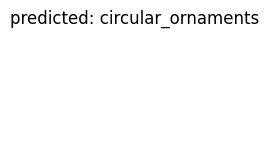

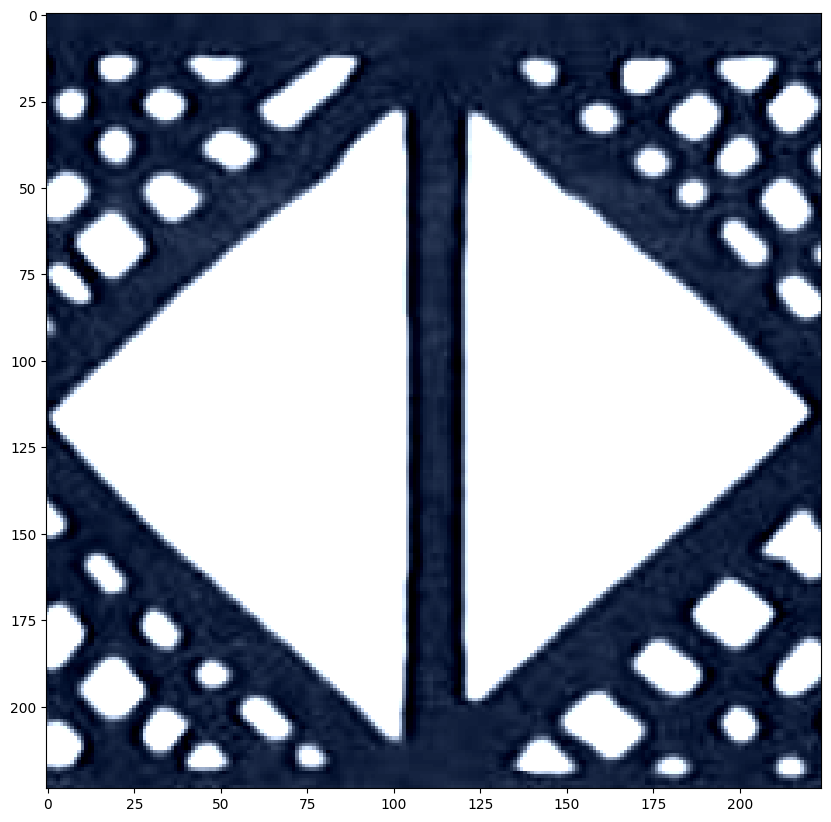

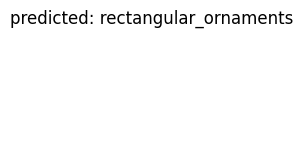

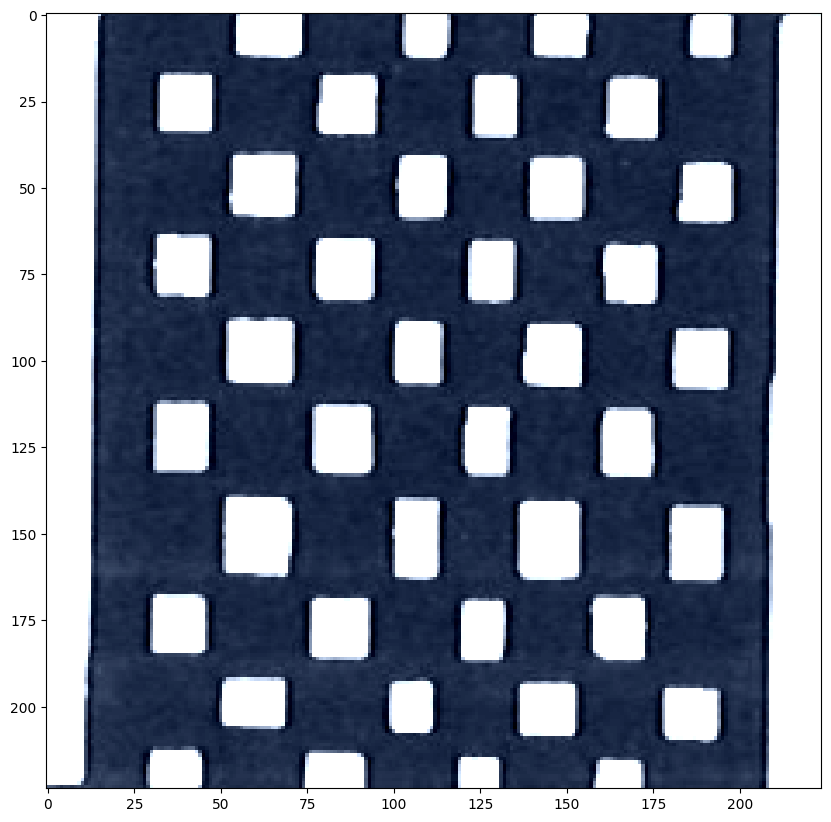

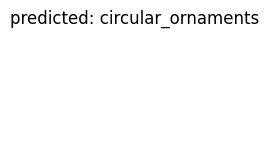

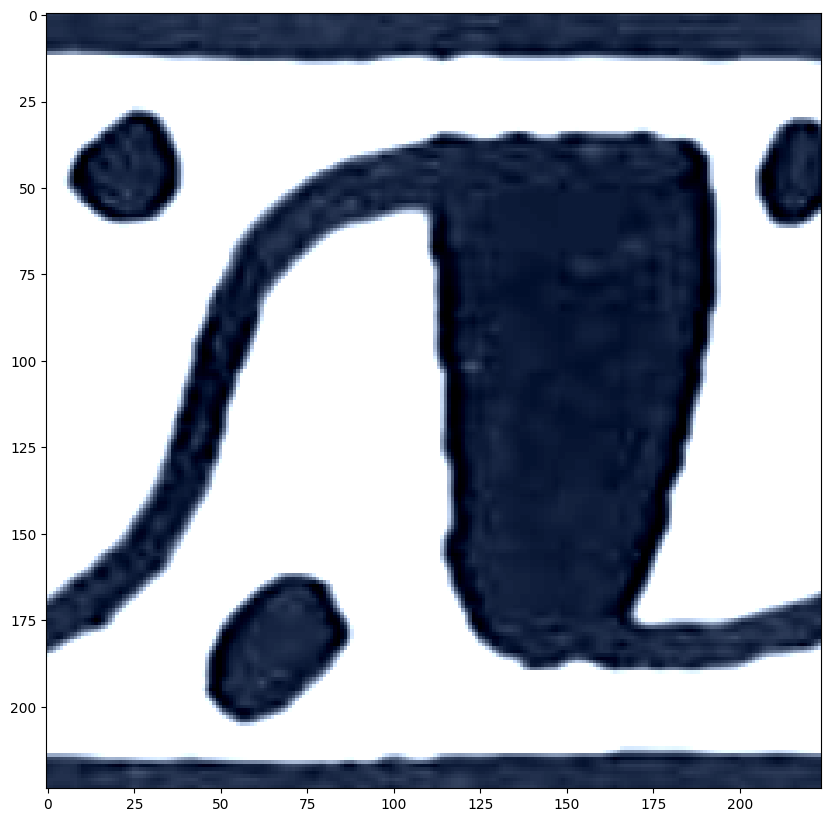

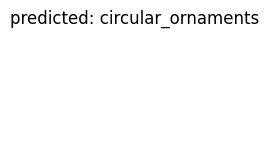

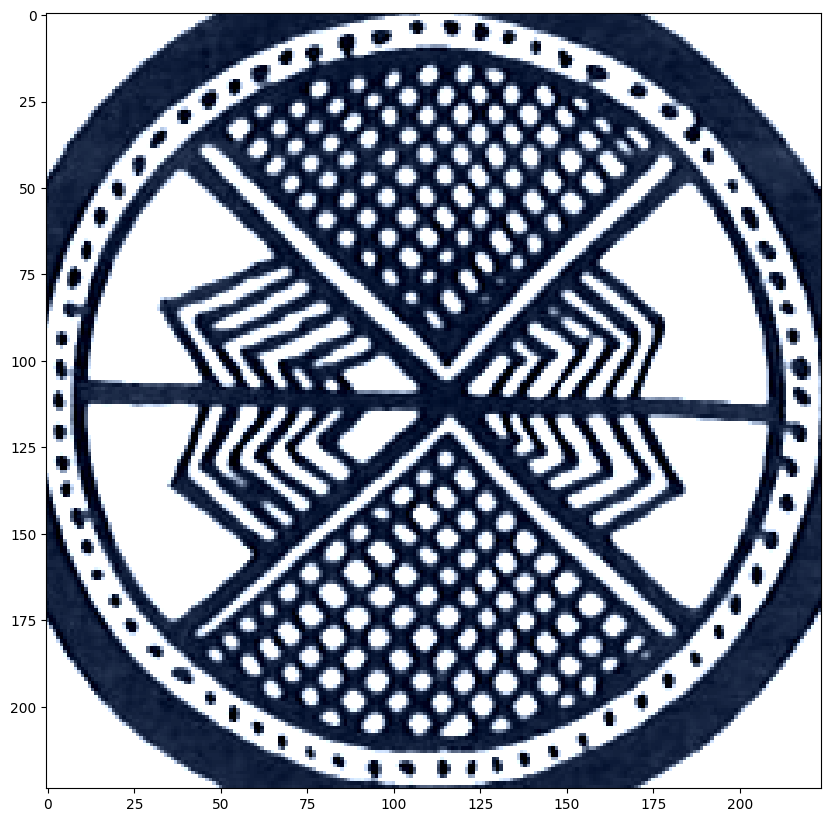

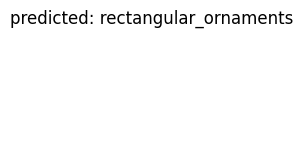

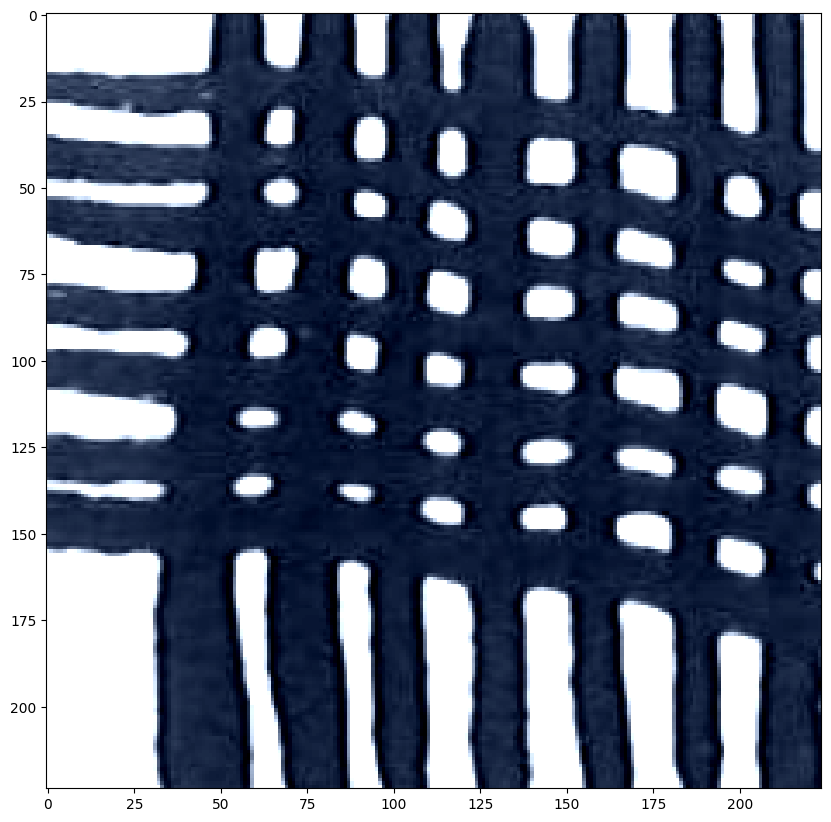

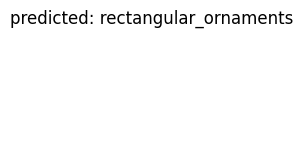

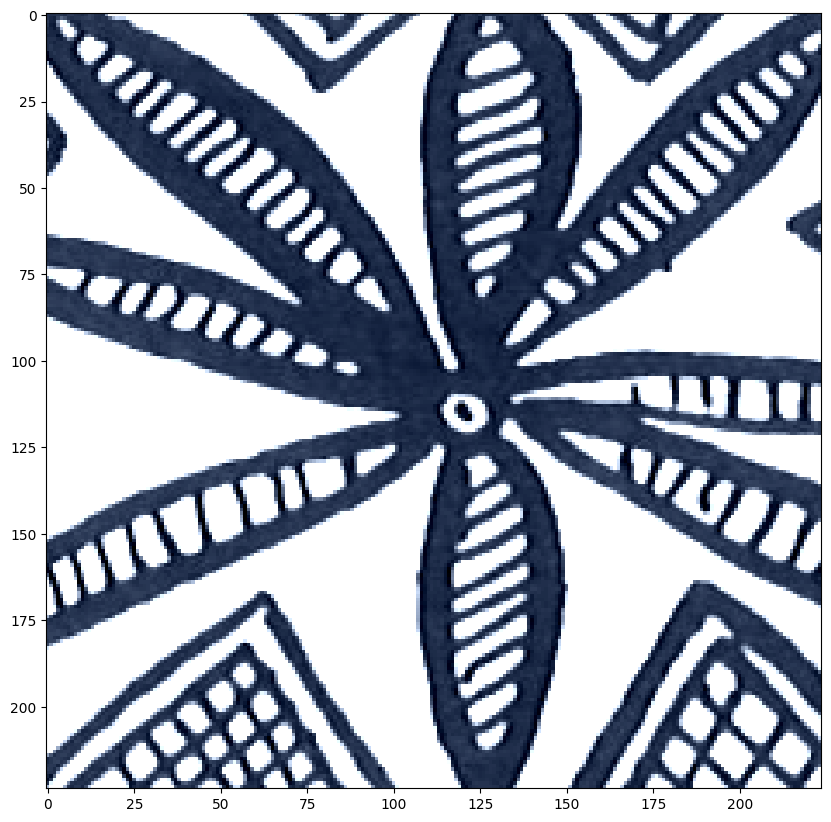

In [17]:
visualize_model(model_ft)

# Solución 2: Freezing

Utiliza freezing para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting
ting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.

In [18]:
# Freeze
model_conv = torchvision.models.resnet50(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
  param.requires_grad = False

num_ft = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ft, len(class_names))

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


Epoch 0/24
----------
Train Loss: 1.7954 Acc: 0.1864
Val Loss: 1.6245 Acc: 0.3684
Epoch 1/24
----------
Train Loss: 1.6425 Acc: 0.4025
Val Loss: 1.5769 Acc: 0.3947
Epoch 2/24
----------
Train Loss: 1.4863 Acc: 0.4788
Val Loss: 1.4591 Acc: 0.5000
Epoch 3/24
----------
Train Loss: 1.3380 Acc: 0.5932
Val Loss: 1.3409 Acc: 0.5263
Epoch 4/24
----------
Train Loss: 1.2578 Acc: 0.5593
Val Loss: 1.2832 Acc: 0.5526
Epoch 5/24
----------
Train Loss: 1.1397 Acc: 0.6144
Val Loss: 1.2654 Acc: 0.5526
Epoch 6/24
----------
Train Loss: 1.1005 Acc: 0.6525
Val Loss: 1.2291 Acc: 0.5789
Epoch 7/24
----------
Train Loss: 1.0441 Acc: 0.6271
Val Loss: 1.2064 Acc: 0.5789
Epoch 8/24
----------
Train Loss: 1.0363 Acc: 0.6356
Val Loss: 1.2104 Acc: 0.5789
Epoch 9/24
----------
Train Loss: 1.0555 Acc: 0.6398
Val Loss: 1.1992 Acc: 0.5789
Epoch 10/24
----------
Train Loss: 1.0479 Acc: 0.6737
Val Loss: 1.2016 Acc: 0.6053
Epoch 11/24
----------
Train Loss: 1.0087 Acc: 0.6864
Val Loss: 1.1992 Acc: 0.5789
Epoch 12/24
--

Como se puede ver en la celda anterior, usando la técnica de Freeze se logran mejores resultados para esta tarea de clasificación de imágenes.  
Notar que la mejora con respecto a la ejecución anterior es notable pues es en más de un 10%.  
Este modelo NO está overfiteado pues la época que nos entrega el mejor accuracy de validación es la época 17, y nos quedamos con ella pues también tiene la menor función de pérdida en el conjunto de validación (en caso de que esto no fuera así y se escogiera otra época, el modelo sí estaría overfiteado).  
Con esto, se alcanza un accuracy de validación de `0.6053` y un accuracy de train de `0.6483`.

In [19]:
# Evaluar en Test
model_conv.eval()
with torch.no_grad():
  test_loss = 0.0
  test_corrects = 0.0

  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model_conv(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    test_loss += loss.item() * inputs.size(0)
    test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss /len(test_dataset)
test_acc = test_corrects.double() / len(test_dataset)

print('Test Accuracy:', test_acc.item())

Test Accuracy: 0.6216216216216217




---

A modo de conclusión, se probaron distintas cosas para la técnica de transfer learning. Ya sean diferentes modelos, optimizadores, pesos e hiperparámetros como learning rate, gamma (scheduler) y número de épocas con el objetivo de mejorar nuestra precisión al clasificar lo más posible.  

Al no existir un objetivo de accuracy en esta tarea, se dejan los resultados obtenidos que se consideran buenos, sin embargo, estos son claramente mejorables ya sea con mayor poder computacional o probando otro tipo de arquitecturas para la última capa de los modelos (por ejemplo, varias lineales o similar).  

Por último, se ve como afecta el poseer pocos datos, por lo que técnicas como data augmentation ayudan bastante en estos casos, pero dada la naturaleza de estos datos se prefiere dejar como está e intentar llegar a un buen resultado solo usando transfer learning.
